### Scenario
Alice is competing in Kaggle's Titanic competitions. Following the advice from an internet article, she tried heavy feature engineering and a simple model. However, she found that the model did not perform as well as what the original article claimed. She wondered what went wrong, but couldn't find the problem despite much effort. **Could you help her find problems in her notebook and improve the model's performance?**

### Instruction
+ You are free to use the Internet to search for any problems you might encounter. However, please do not try to search the code directly.
+ You overall goal is to improve the model's performance, but you might prioritize finding the underlying problems in the notebook.


In [1170]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

# II - Feature engineering

In [1171]:
def status(feature):
    print('Processing', feature, ': ok')

###  Loading the data

One trick when starting a machine learning problem is to append the training set to the test set together.

We'll engineer new features using the train set to prevent information leakage. Then we'll add these variables to the test set.

Let's load the train and test sets and append them together.


**output**
- combined, shape(1309, 10), column types: {int64: 3, object: 5, float64: 2}

|         |   Pclass | Name                    | Sex   |   Age |   SibSp |   Parch | Ticket    |   Fare |   Cabin | Embarked   |
|:--------|---------:|:------------------------|:------|------:|--------:|--------:|:----------|-------:|--------:|:-----------|
| example |        3 | Braund, Mr. Owen Harris | male  |    22 |       1 |       0 | A/5 21171 |   7.25 |     nan | S          |
- train_len, <class 'int'>, 891

In [1172]:
# reading train data
train = pd.read_csv('./data/train.csv')
train_len = len(train)

# reading test data
test = pd.read_csv('./data/test.csv')

# extracting and then removing the targets from the training data 
targets = train.Survived
train.drop(['Survived'], 1, inplace=True)


# merging train data and test data for future feature engineering
# we'll also remove the PassengerID since this is not an informative feature
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

### Processing Title

**input**
- combined, shape(1309, 10), column types: {int64: 3, object: 5, float64: 2}

In [1173]:
titles = set()
for name in combined['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

**input**
- combined, shape(1309, 10), column types: {int64: 3, object: 5, float64: 2}

**output**
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}
	- add columns {'Title'}

|         |   Pclass | Name                    | Sex   |   Age |   SibSp |   Parch | Ticket    |   Fare |   Cabin | Embarked   |   Title |
|:--------|---------:|:------------------------|:------|------:|--------:|--------:|:----------|-------:|--------:|:-----------|--------:|
| example |        3 | Braund, Mr. Owen Harris | male  |    22 |       1 |       0 | A/5 21171 |   7.25 |     nan | S          |     nan |

In [1174]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

# we extract the title from each name
combined['Title'] = combined['Name'].map(lambda name:name.split('.')[0].strip())

# a map of more aggregated title
# we map each title
combined['Title'] = combined.Title.map(Title_Dictionary)
status('Title')

Processing Title : ok


**input**
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}

**output**
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}
	- 1 object columns changed

|          |   Pclass | Name                    | Sex   |   Age |   SibSp |   Parch | Ticket    |   Fare |   Cabin | Embarked   | Title*         |
|:---------|---------:|:------------------------|:------|------:|--------:|--------:|:----------|-------:|--------:|:-----------|:---------------|
| example0 |        3 | Braund, Mr. Owen Harris | male  |    22 |       1 |       0 | A/5 21171 |   7.25 |     nan | S          | nan -> Royalty |

In [1175]:
combined[combined['Title'].isnull()]
combined.at[combined['Title'].isnull(), "Title"] = "Royalty"

### Processing Ages

**input**
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}
- train_len, <class 'int'>

**output**
- grouped_median_train, shape(6, 4), column types: {object: 2, int64: 1, float64: 1}

|         | Sex    |   Pclass | Title   |   Age |
|:--------|:-------|---------:|:--------|------:|
| example | female |        1 | Royalty |    35 |

In [1176]:
grouped_train = combined.iloc[:train_len].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

**input**
- grouped_median_train, shape(6, 4), column types: {object: 2, int64: 1, float64: 1}
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}

**output**
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}
	- 1 float64 columns changed

|          |   Pclass | Name                    | Sex   | Age*         |   SibSp |   Parch | Ticket    |   Fare |   Cabin | Embarked   | Title   |
|:---------|---------:|:------------------------|:------|:-------------|--------:|--------:|:----------|-------:|--------:|:-----------|:--------|
| example0 |        3 | Braund, Mr. Owen Harris | male  | 22.0 -> 25.0 |       1 |       0 | A/5 21171 |   7.25 |     nan | S          | Royalty |

In [1177]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

combined['Age'] = combined.apply(lambda row: fill_age(row), axis=1)
status('age')

Processing age : ok


Let's now process the names.

**input**
- combined, shape(1309, 11), column types: {int64: 3, object: 6, float64: 2}

**output**
- combined, shape(1309, 10), column types: {int64: 3, object: 4, float64: 2, uint8: 1}
	- add columns {'Title_Royalty'} remove columns {'Name', 'Title'}

|         |   Pclass | Sex   |   Age |   SibSp |   Parch | Ticket    |   Fare |   Cabin | Embarked   |   Title_Royalty |
|:--------|---------:|:------|------:|--------:|--------:|:----------|-------:|--------:|:-----------|----------------:|
| example |        3 | male  |    25 |       1 |       0 | A/5 21171 |   7.25 |     nan | S          |               1 |

In [1178]:
# we clean the Name variable
combined.drop('Name', axis=1, inplace=True)

# encoding in dummy variable
titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
combined = pd.concat([combined, titles_dummies], axis=1)

# removing the title variable
combined.drop('Title', axis=1, inplace=True)

status('names')

Processing names : ok


### Processing Fare

**input**
- combined, shape(1309, 10), column types: {int64: 3, object: 4, float64: 2, uint8: 1}
- train_len, <class 'int'>

In [1179]:
# there's one missing fare value - replacing it with the mean.
combined.Fare.fillna(combined.iloc[:train_len].Fare.mean(), inplace=True)
status('fare')

Processing fare : ok


### Processing Embarked

**input**
- combined, shape(1309, 10), column types: {int64: 3, object: 4, float64: 2, uint8: 1}

**output**
- combined, shape(1309, 12), column types: {int64: 3, object: 3, float64: 2, uint8: 4}
	- add columns {'Embarked_Q', 'Embarked_C', 'Embarked_S'} remove columns {'Embarked'}

|         |   Pclass | Sex   |   Age |   SibSp |   Parch | Ticket    |   Fare |   Cabin |   Title_Royalty |   Embarked_C |   Embarked_Q |   Embarked_S |
|:--------|---------:|:------|------:|--------:|--------:|:----------|-------:|--------:|----------------:|-------------:|-------------:|-------------:|
| example |        3 | male  |    25 |       1 |       0 | A/5 21171 |   7.25 |     nan |               1 |            0 |            0 |            1 |

In [1180]:
# two missing embarked values - filling them with the most frequent one in the train  set(S)
combined.Embarked.fillna('S', inplace=True)
# dummy encoding 
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop('Embarked', axis=1, inplace=True)
status('embarked')
combined.Cabin

Processing embarked : ok


0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

### Processing Cabin

**input**
- combined, shape(1309, 12), column types: {int64: 3, object: 3, float64: 2, uint8: 4}

**output**
- combined, shape(1309, 20), column types: {int64: 3, object: 2, float64: 2, uint8: 13}
	- add columns {'Cabin_E', 'Cabin_G', 'Cabin_F', 'Cabin_B', 'Cabin_D', 'Cabin_C', 'Cabin_T', 'Cabin_A', 'Cabin_U'} remove columns {'Cabin'}

|         |   Pclass | Sex   |   Age |   SibSp |   Parch | Ticket    |   Fare |   Title_Royalty |   Embarked_C |   Embarked_Q |   Embarked_S |   Cabin_A |   Cabin_B |   Cabin_C |   Cabin_D |   Cabin_E |   Cabin_F |   Cabin_G |   Cabin_T |   Cabin_U |
|:--------|---------:|:------|------:|--------:|--------:|:----------|-------:|----------------:|-------------:|-------------:|-------------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| example |        3 | male  |    25 |       1 |       0 | A/5 21171 |   7.25 |               1 |            0 |            0 |            1 |         0 |         0 |         0 |         0 |         0 |         0 |         0 |         0 |         1 |

In [1181]:
# replacing missing cabins with U (for Uknown)
combined.Cabin.fillna('U', inplace=True)

# mapping each Cabin value with the cabin letter
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

# dummy encoding ...
cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
combined = pd.concat([combined, cabin_dummies], axis=1)

combined.drop('Cabin', axis=1, inplace=True)
status('cabin')

Processing cabin : ok


This function replaces NaN values with U (for <i>Unknow</i>). It then maps each Cabin value to the first letter.
Then it encodes the cabin values using dummy encoding again.

Ok no missing values now.

### Processing Sex

**input**
- combined, shape(1309, 20), column types: {int64: 3, object: 2, float64: 2, uint8: 13}

**output**
- combined, shape(1309, 20), column types: {int64: 4, float64: 2, object: 1, uint8: 13}
	- 1 object columns converted to int64

|          |   Pclass | Sex*      |   Age |   SibSp |   Parch | Ticket    |   Fare |   Title_Royalty |   Embarked_C |   Embarked_Q |   Embarked_S |   Cabin_A |   Cabin_B |   Cabin_C |   Cabin_D |   Cabin_E |   Cabin_F |   Cabin_G |   Cabin_T |   Cabin_U |
|:---------|---------:|:----------|------:|--------:|--------:|:----------|-------:|----------------:|-------------:|-------------:|-------------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| example0 |        3 | male -> 1 |    25 |       1 |       0 | A/5 21171 |   7.25 |               1 |            0 |            0 |            1 |         0 |         0 |         0 |         0 |         0 |         0 |         0 |         0 |         1 |

In [1182]:
# mapping string values to numerical one 
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
status('Sex')

Processing Sex : ok


This function maps the string values male and female to 1 and 0 respectively. 

### Processing Pclass

**input**
- combined, shape(1309, 20), column types: {int64: 4, float64: 2, object: 1, uint8: 13}

**output**
- combined, shape(1309, 22), column types: {int64: 3, float64: 2, object: 1, uint8: 16}
	- add columns {'Pclass_1', 'Pclass_2', 'Pclass_3'} remove columns {'Pclass'}

|         |   Sex |   Age |   SibSp |   Parch | Ticket    |   Fare |   Title_Royalty |   Embarked_C |   Embarked_Q |   Embarked_S |   Cabin_A |   Cabin_B |   Cabin_C |   Cabin_D |   Cabin_E |   Cabin_F |   Cabin_G |   Cabin_T |   Cabin_U |   Pclass_1 |   Pclass_2 |   Pclass_3 |
|:--------|------:|------:|--------:|--------:|:----------|-------:|----------------:|-------------:|-------------:|-------------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|
| example |     1 |    25 |       1 |       0 | A/5 21171 |   7.25 |               1 |            0 |            0 |            1 |         0 |         0 |         0 |         0 |         0 |         0 |         0 |         0 |         1 |          0 |          0 |          1 |

In [1183]:
# encoding into 3 categories:
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")

# adding dummy variable
combined = pd.concat([combined, pclass_dummies],axis=1)

# removing "Pclass"
combined.drop('Pclass',axis=1,inplace=True)

status('Pclass')

Processing Pclass : ok


This function encodes the values of Pclass (1,2,3) using a dummy encoding.

### Processing Ticket

Let's first see how the different ticket prefixes we have in our dataset

**input**
- combined, shape(1309, 22), column types: {int64: 3, float64: 2, object: 1, uint8: 16}

**output**
- combined, shape(1309, 58), column types: {int64: 3, float64: 2, uint8: 53}
	- add columns {'Ticket_XXX', 'Ticket_PP', 'Ticket_STONOQ', 'Ticket_STONO2', 'Ticket_SP', 'Ticket_SOTONO2', 'Ticket_SCA3', 'Ticket_C', 'Ticket_A5', 'Ticket_SCOW', 'Ticket_SCAH', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_WEP', 'Ticket_PC', 'Ticket_LP', 'Ticket_SOC', 'Ticket_AQ3', 'Ticket_AS', 'Ticket_LINE', 'Ticket_STONO', 'Ticket_A', 'Ticket_WC', 'Ticket_SOP', 'Ticket_CA', 'Ticket_PPP', 'Ticket_SOPP', 'Ticket_SC', 'Ticket_A4', 'Ticket_AQ4', 'Ticket_FC', 'Ticket_SWPP', 'Ticket_FCC', 'Ticket_CASOTON', 'Ticket_SOTONOQ', 'Ticket_SCA4', 'Ticket_Fa'} remove columns {'Ticket'}

|          | Sex                 | Age                | SibSp              | Parch              | Fare              | Title_Royalty   | Embarked_C          | Embarked_Q          | Embarked_S          | Cabin_A              | Cabin_B             | Cabin_C             | Cabin_D             | Cabin_E              | Cabin_F              | Cabin_G               | Cabin_T               | Cabin_U             | Pclass_1            | Pclass_2            | Pclass_3            | Ticket_A              | Ticket_A4             | Ticket_A5            | Ticket_AQ3            | Ticket_AQ4            | Ticket_AS             | Ticket_C             | Ticket_CA           | Ticket_CASOTON        | Ticket_FC            | Ticket_FCC           | Ticket_Fa             | Ticket_LINE           | Ticket_LP             | Ticket_PC           | Ticket_PP             | Ticket_PPP            | Ticket_SC             | Ticket_SCA3           | Ticket_SCA4           | Ticket_SCAH           | Ticket_SCOW           | Ticket_SCPARIS       | Ticket_SCParis        | Ticket_SOC           | Ticket_SOP            | Ticket_SOPP          | Ticket_SOTONO2        | Ticket_SOTONOQ       | Ticket_SP             | Ticket_STONO         | Ticket_STONO2        | Ticket_STONOQ         | Ticket_SWPP           | Ticket_WC            | Ticket_WEP            | Ticket_XXX          |
|:---------|:--------------------|:-------------------|:-------------------|:-------------------|:------------------|:----------------|:--------------------|:--------------------|:--------------------|:---------------------|:--------------------|:--------------------|:--------------------|:---------------------|:---------------------|:----------------------|:----------------------|:--------------------|:--------------------|:--------------------|:--------------------|:----------------------|:----------------------|:---------------------|:----------------------|:----------------------|:----------------------|:---------------------|:--------------------|:----------------------|:---------------------|:---------------------|:----------------------|:----------------------|:----------------------|:--------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:---------------------|:---------------------|:----------------------|:----------------------|:---------------------|:----------------------|:--------------------|
| example  | 1.0                 | 25.0               | 1.0                | 0.0                | 7.25              | 1.0             | 0.0                 | 0.0                 | 1.0                 | 0.0                  | 0.0                 | 0.0                 | 0.0                 | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 1.0                 | 0.0                 | 0.0                 | 1.0                 | 0.0                   | 0.0                   | 1.0                  | 0.0                   | 0.0                   | 0.0                   | 0.0                  | 0.0                 | 0.0                   | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 0.0                   | 0.0                 | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 0.0                  | 0.0                   | 0.0                 |
| mean     | 0.6440030557677616  | 28.469824293353707 | 0.4988540870893812 | 0.3850267379679144 | 33.29464561342137 | 1.0             | 0.20626432391138275 | 0.09396485867074103 | 0.6997708174178763  | 0.01680672268907563  | 0.04965622612681436 | 0.0718105423987777  | 0.03514132925897632 | 0.03132161955691368  | 0.016042780748663103 | 0.0038197097020626434 | 0.0007639419404125286 | 0.774637127578304   | 0.24675324675324675 | 0.21161191749427044 | 0.5416348357524828  | 0.0007639419404125286 | 0.007639419404125287  | 0.0213903743315508   | 0.0007639419404125286 | 0.0007639419404125286 | 0.0007639419404125286 | 0.006111535523300229 | 0.05194805194805195 | 0.0007639419404125286 | 0.002291825821237586 | 0.006875477463712758 | 0.0007639419404125286 | 0.0030557677616501145 | 0.0007639419404125286 | 0.07028265851795264 | 0.0030557677616501145 | 0.0015278838808250573 | 0.0015278838808250573 | 0.0007639419404125286 | 0.0015278838808250573 | 0.0038197097020626434 | 0.0007639419404125286 | 0.0106951871657754   | 0.0038197097020626434 | 0.006111535523300229 | 0.0007639419404125286 | 0.0053475935828877   | 0.002291825821237586  | 0.01833460656990069  | 0.0007639419404125286 | 0.0106951871657754   | 0.0053475935828877   | 0.0007639419404125286 | 0.0015278838808250573 | 0.01145912910618793  | 0.0030557677616501145 | 0.7310924369747899  |
| variance | 0.22926311992954698 | 35.744887746056136 | 1.0842232858140826 | 0.7486222490940956 | 2674.867507554873 | 0.0             | 0.1637193525927629  | 0.08513546400572869 | 0.21009162050819358 | 0.016524256761528137 | 0.04719048533365706 | 0.06665378839917105 | 0.03390641623688854 | 0.030340575705245638 | 0.015785409934513425 | 0.0038051195198546125 | 0.000763358333124207  | 0.17457444815553835 | 0.1858660819699781  | 0.16683231386866854 | 0.24826654045186378 | 0.0007633583331242073 | 0.0075810586752931616 | 0.020932826217506934 | 0.0007633583331242074 | 0.0007633583331242072 | 0.0007633583331242073 | 0.006074184656847666 | 0.04924945184685444 | 0.0007633583331242075 | 0.002286573355642695 | 0.006828205273358738 | 0.0007633583331242074 | 0.0030464300450369747 | 0.0007633583331242074 | 0.06534300642960149 | 0.003046430045036975  | 0.0015255494516717722 | 0.0015255494516717724 | 0.0007633583331242073 | 0.0015255494516717724 | 0.0038051195198546125 | 0.0007633583331242074 | 0.010580800137264432 | 0.0038051195198546117 | 0.006074184656847666 | 0.0007633583331242073 | 0.005318996825759958 | 0.0022865733556426946 | 0.017998448771827644 | 0.0007633583331242073 | 0.010580800137264432 | 0.005318996825759958 | 0.0007633583331242073 | 0.0015255494516717726 | 0.011327817466315643 | 0.003046430045036975  | 0.19659628557305275 |
| range    | [0.0, 1.0]          | [21.5, 40.0]       | [0.0, 8.0]         | [0.0, 9.0]         | [0.0, 512.3292]   | [1.0, 1.0]      | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]          |

In [1184]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'


# Extracting dummy variables from tickets:

combined['Ticket'] = combined['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
combined = pd.concat([combined, tickets_dummies], axis=1)
combined.drop('Ticket', inplace=True, axis=1)

status('Ticket')

Processing Ticket : ok


### Processing Family

**input**
- combined, shape(1309, 58), column types: {int64: 3, float64: 2, uint8: 53}

**output**
- combined, shape(1309, 62), column types: {int64: 7, float64: 2, uint8: 53}
	- add columns {'FamilySize', 'Singleton', 'LargeFamily', 'SmallFamily'}

|          | Sex                 | Age                | SibSp              | Parch              | Fare              | Title_Royalty   | Embarked_C          | Embarked_Q          | Embarked_S          | Cabin_A              | Cabin_B             | Cabin_C             | Cabin_D             | Cabin_E              | Cabin_F              | Cabin_G               | Cabin_T               | Cabin_U             | Pclass_1            | Pclass_2            | Pclass_3            | Ticket_A              | Ticket_A4             | Ticket_A5            | Ticket_AQ3            | Ticket_AQ4            | Ticket_AS             | Ticket_C             | Ticket_CA           | Ticket_CASOTON        | Ticket_FC            | Ticket_FCC           | Ticket_Fa             | Ticket_LINE           | Ticket_LP             | Ticket_PC           | Ticket_PP             | Ticket_PPP            | Ticket_SC             | Ticket_SCA3           | Ticket_SCA4           | Ticket_SCAH           | Ticket_SCOW           | Ticket_SCPARIS       | Ticket_SCParis        | Ticket_SOC           | Ticket_SOP            | Ticket_SOPP          | Ticket_SOTONO2        | Ticket_SOTONOQ       | Ticket_SP             | Ticket_STONO         | Ticket_STONO2        | Ticket_STONOQ         | Ticket_SWPP           | Ticket_WC            | Ticket_WEP            | Ticket_XXX          | FamilySize         | Singleton           | SmallFamily         | LargeFamily          |
|:---------|:--------------------|:-------------------|:-------------------|:-------------------|:------------------|:----------------|:--------------------|:--------------------|:--------------------|:---------------------|:--------------------|:--------------------|:--------------------|:---------------------|:---------------------|:----------------------|:----------------------|:--------------------|:--------------------|:--------------------|:--------------------|:----------------------|:----------------------|:---------------------|:----------------------|:----------------------|:----------------------|:---------------------|:--------------------|:----------------------|:---------------------|:---------------------|:----------------------|:----------------------|:----------------------|:--------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:---------------------|:----------------------|:---------------------|:---------------------|:----------------------|:----------------------|:---------------------|:----------------------|:--------------------|:-------------------|:--------------------|:--------------------|:---------------------|
| example  | 1.0                 | 25.0               | 1.0                | 0.0                | 7.25              | 1.0             | 0.0                 | 0.0                 | 1.0                 | 0.0                  | 0.0                 | 0.0                 | 0.0                 | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 1.0                 | 0.0                 | 0.0                 | 1.0                 | 0.0                   | 0.0                   | 1.0                  | 0.0                   | 0.0                   | 0.0                   | 0.0                  | 0.0                 | 0.0                   | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 0.0                   | 0.0                 | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                   | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 0.0                  | 0.0                   | 0.0                 | 2.0                | 0.0                 | 1.0                 | 0.0                  |
| mean     | 0.6440030557677616  | 28.469824293353707 | 0.4988540870893812 | 0.3850267379679144 | 33.29464561342137 | 1.0             | 0.20626432391138275 | 0.09396485867074103 | 0.6997708174178763  | 0.01680672268907563  | 0.04965622612681436 | 0.0718105423987777  | 0.03514132925897632 | 0.03132161955691368  | 0.016042780748663103 | 0.0038197097020626434 | 0.0007639419404125286 | 0.774637127578304   | 0.24675324675324675 | 0.21161191749427044 | 0.5416348357524828  | 0.0007639419404125286 | 0.007639419404125287  | 0.0213903743315508   | 0.0007639419404125286 | 0.0007639419404125286 | 0.0007639419404125286 | 0.006111535523300229 | 0.05194805194805195 | 0.0007639419404125286 | 0.002291825821237586 | 0.006875477463712758 | 0.0007639419404125286 | 0.0030557677616501145 | 0.0007639419404125286 | 0.07028265851795264 | 0.0030557677616501145 | 0.0015278838808250573 | 0.0015278838808250573 | 0.0007639419404125286 | 0.0015278838808250573 | 0.0038197097020626434 | 0.0007639419404125286 | 0.0106951871657754   | 0.0038197097020626434 | 0.006111535523300229 | 0.0007639419404125286 | 0.0053475935828877   | 0.002291825821237586  | 0.01833460656990069  | 0.0007639419404125286 | 0.0106951871657754   | 0.0053475935828877   | 0.0007639419404125286 | 0.0015278838808250573 | 0.01145912910618793  | 0.0030557677616501145 | 0.7310924369747899  | 1.8838808250572956 | 0.6035141329258976  | 0.33384262796027503 | 0.06264323911382735  |
| variance | 0.22926311992954698 | 35.744887746056136 | 1.0842232858140826 | 0.7486222490940956 | 2674.867507554873 | 0.0             | 0.1637193525927629  | 0.08513546400572869 | 0.21009162050819358 | 0.016524256761528137 | 0.04719048533365706 | 0.06665378839917105 | 0.03390641623688854 | 0.030340575705245638 | 0.015785409934513425 | 0.0038051195198546125 | 0.000763358333124207  | 0.17457444815553835 | 0.1858660819699781  | 0.16683231386866854 | 0.24826654045186378 | 0.0007633583331242073 | 0.0075810586752931616 | 0.020932826217506934 | 0.0007633583331242074 | 0.0007633583331242072 | 0.0007633583331242073 | 0.006074184656847666 | 0.04924945184685444 | 0.0007633583331242075 | 0.002286573355642695 | 0.006828205273358738 | 0.0007633583331242074 | 0.0030464300450369747 | 0.0007633583331242074 | 0.06534300642960149 | 0.003046430045036975  | 0.0015255494516717722 | 0.0015255494516717724 | 0.0007633583331242073 | 0.0015255494516717724 | 0.0038051195198546125 | 0.0007633583331242074 | 0.010580800137264432 | 0.0038051195198546117 | 0.006074184656847666 | 0.0007633583331242073 | 0.005318996825759958 | 0.0022865733556426946 | 0.017998448771827644 | 0.0007633583331242073 | 0.010580800137264432 | 0.005318996825759958 | 0.0007633583331242073 | 0.0015255494516717726 | 0.011327817466315643 | 0.003046430045036975  | 0.19659628557305275 | 2.505996856691145  | 0.23928482428459957 | 0.22239172771685237 | 0.058719063707155184 |
| range    | [0.0, 1.0]          | [21.5, 40.0]       | [0.0, 8.0]         | [0.0, 9.0]         | [0.0, 512.3292]   | [1.0, 1.0]      | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]          | [1.0, 11.0]        | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           |

In [1185]:
# introducing a new feature : the size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

# introducing other features based on the family size
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

status('family')

Processing family : ok


# III - Modeling

In [1186]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [1187]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

Recovering the train set and the test set from the combined dataset is an easy task.

**input**
- combined, shape(1309, 62), column types: {int64: 7, float64: 2, uint8: 53}

**output**
- train, shape(891, 62), column types: {int64: 7, float64: 2, uint8: 53}

|          | Sex                 | Age                | SibSp              | Parch               | Fare               | Title_Royalty   | Embarked_C          | Embarked_Q          | Embarked_S          | Cabin_A              | Cabin_B              | Cabin_C             | Cabin_D              | Cabin_E             | Cabin_F              | Cabin_G              | Cabin_T              | Cabin_U            | Pclass_1            | Pclass_2            | Pclass_3            | Ticket_A   | Ticket_A4            | Ticket_A5           | Ticket_AQ3   | Ticket_AQ4   | Ticket_AS            | Ticket_C             | Ticket_CA           | Ticket_CASOTON       | Ticket_FC            | Ticket_FCC           | Ticket_Fa            | Ticket_LINE          | Ticket_LP   | Ticket_PC           | Ticket_PP            | Ticket_PPP           | Ticket_SC            | Ticket_SCA3   | Ticket_SCA4          | Ticket_SCAH          | Ticket_SCOW          | Ticket_SCPARIS       | Ticket_SCParis       | Ticket_SOC           | Ticket_SOP           | Ticket_SOPP          | Ticket_SOTONO2       | Ticket_SOTONOQ       | Ticket_SP            | Ticket_STONO         | Ticket_STONO2        | Ticket_STONOQ   | Ticket_SWPP          | Ticket_WC            | Ticket_WEP           | Ticket_XXX         | FamilySize        | Singleton           | SmallFamily        | LargeFamily         |
|:---------|:--------------------|:-------------------|:-------------------|:--------------------|:-------------------|:----------------|:--------------------|:--------------------|:--------------------|:---------------------|:---------------------|:--------------------|:---------------------|:--------------------|:---------------------|:---------------------|:---------------------|:-------------------|:--------------------|:--------------------|:--------------------|:-----------|:---------------------|:--------------------|:-------------|:-------------|:---------------------|:---------------------|:--------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:------------|:--------------------|:---------------------|:---------------------|:---------------------|:--------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:----------------|:---------------------|:---------------------|:---------------------|:-------------------|:------------------|:--------------------|:-------------------|:--------------------|
| example  | 1.0                 | 25.0               | 1.0                | 0.0                 | 7.25               | 1.0             | 0.0                 | 0.0                 | 1.0                 | 0.0                  | 0.0                  | 0.0                 | 0.0                  | 0.0                 | 0.0                  | 0.0                  | 0.0                  | 1.0                | 0.0                 | 0.0                 | 1.0                 | 0.0        | 0.0                  | 1.0                 | 0.0          | 0.0          | 0.0                  | 0.0                  | 0.0                 | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0         | 0.0                 | 0.0                  | 0.0                  | 0.0                  | 0.0           | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0             | 0.0                  | 0.0                  | 0.0                  | 0.0                | 2.0               | 0.0                 | 1.0                | 0.0                 |
| mean     | 0.6475869809203143  | 28.40516273849607  | 0.5230078563411896 | 0.38159371492704824 | 32.204207968574636 | 1.0             | 0.18855218855218855 | 0.08641975308641975 | 0.7250280583613917  | 0.016835016835016835 | 0.052749719416386086 | 0.06621773288439955 | 0.037037037037037035 | 0.03591470258136925 | 0.014590347923681257 | 0.004489337822671156 | 0.001122334455667789 | 0.7710437710437711 | 0.24242424242424243 | 0.20650953984287318 | 0.5510662177328844  | 0.0        | 0.007856341189674524 | 0.02356902356902357 | 0.0          | 0.0          | 0.001122334455667789 | 0.005611672278338945 | 0.04601571268237935 | 0.001122334455667789 | 0.001122334455667789 | 0.005611672278338945 | 0.001122334455667789 | 0.004489337822671156 | 0.0         | 0.06734006734006734 | 0.003367003367003367 | 0.002244668911335578 | 0.001122334455667789 | 0.0           | 0.001122334455667789 | 0.003367003367003367 | 0.001122334455667789 | 0.007856341189674524 | 0.004489337822671156 | 0.006734006734006734 | 0.001122334455667789 | 0.003367003367003367 | 0.002244668911335578 | 0.016835016835016835 | 0.001122334455667789 | 0.013468013468013467 | 0.006734006734006734 | 0.0             | 0.002244668911335578 | 0.01122334455667789  | 0.003367003367003367 | 0.7418630751964085 | 1.904601571268238 | 0.6026936026936027  | 0.3277216610549944 | 0.06958473625140292 |
| variance | 0.22821808306282676 | 35.540669193493734 | 1.2146782704208816 | 0.6489990313409693  | 2466.665311685043  | 0.0             | 0.1530002607443685  | 0.07895137936290199 | 0.19936237295010206 | 0.01655159904318153  | 0.04996718651787863  | 0.06183294473604983 | 0.03566529492455418  | 0.03462483671986104 | 0.014377469671147182 | 0.00446918366858509  | 0.00112107482103741  | 0.1765352741783718 | 0.18365472910927452 | 0.16386334979675798 | 0.24739224140645757 | 0.0        | 0.007794619092785948 | 0.02301352469702639 | 0.0          | 0.0          | 0.00112107482103741  | 0.005580181412579468 | 0.04389826686871205 | 0.00112107482103741  | 0.00112107482103741  | 0.005580181412579468 | 0.00112107482103741  | 0.004469183668585091 | 0.0         | 0.06280538267070253 | 0.003355666655329955 | 0.002239630372814062 | 0.00112107482103741  | 0.0           | 0.00112107482103741  | 0.003355666655329956 | 0.00112107482103741  | 0.007794619092785947 | 0.004469183668585091 | 0.006688659887313086 | 0.00112107482103741  | 0.003355666655329955 | 0.002239630372814062 | 0.01655159904318153  | 0.00112107482103741  | 0.013286626081238881 | 0.006688659887313086 | 0.0             | 0.002239630372814062 | 0.011097381093639981 | 0.003355666655329955 | 0.1915022528565364 | 2.600326749223121 | 0.23945402396580845 | 0.2203201739303497 | 0.0647427007322256  |
| range    | [0.0, 1.0]          | [21.5, 40.0]       | [0.0, 8.0]         | [0.0, 6.0]          | [0.0, 512.3292]    | [1.0, 1.0]      | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]         | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 0.0] | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 0.0]   | [0.0, 0.0]   | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]  | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]    | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]      | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]         | [1.0, 11.0]       | [0.0, 1.0]          | [0.0, 1.0]         | [0.0, 1.0]          |
- targets, shape(891,) of int64
	- mean: 0.3838, variance: 0.2365, range: [0, 1]
- test, shape(418, 62), column types: {int64: 7, float64: 2, uint8: 53}

|          | Sex                 | Age                | SibSp              | Parch              | Fare              | Title_Royalty   | Embarked_C          | Embarked_Q          | Embarked_S          | Cabin_A              | Cabin_B            | Cabin_C             | Cabin_D              | Cabin_E             | Cabin_F              | Cabin_G               | Cabin_T    | Cabin_U             | Pclass_1            | Pclass_2            | Pclass_3            | Ticket_A              | Ticket_A4            | Ticket_A5            | Ticket_AQ3            | Ticket_AQ4            | Ticket_AS   | Ticket_C             | Ticket_CA            | Ticket_CASOTON   | Ticket_FC            | Ticket_FCC           | Ticket_Fa   | Ticket_LINE   | Ticket_LP             | Ticket_PC           | Ticket_PP             | Ticket_PPP   | Ticket_SC             | Ticket_SCA3           | Ticket_SCA4           | Ticket_SCAH          | Ticket_SCOW   | Ticket_SCPARIS       | Ticket_SCParis        | Ticket_SOC            | Ticket_SOP   | Ticket_SOPP          | Ticket_SOTONO2        | Ticket_SOTONOQ       | Ticket_SP   | Ticket_STONO         | Ticket_STONO2         | Ticket_STONOQ         | Ticket_SWPP   | Ticket_WC            | Ticket_WEP            | Ticket_XXX          | FamilySize         | Singleton           | SmallFamily         | LargeFamily         |
|:---------|:--------------------|:-------------------|:-------------------|:-------------------|:------------------|:----------------|:--------------------|:--------------------|:--------------------|:---------------------|:-------------------|:--------------------|:---------------------|:--------------------|:---------------------|:----------------------|:-----------|:--------------------|:--------------------|:--------------------|:--------------------|:----------------------|:---------------------|:---------------------|:----------------------|:----------------------|:------------|:---------------------|:---------------------|:-----------------|:---------------------|:---------------------|:------------|:--------------|:----------------------|:--------------------|:----------------------|:-------------|:----------------------|:----------------------|:----------------------|:---------------------|:--------------|:---------------------|:----------------------|:----------------------|:-------------|:---------------------|:----------------------|:---------------------|:------------|:---------------------|:----------------------|:----------------------|:--------------|:---------------------|:----------------------|:--------------------|:-------------------|:--------------------|:--------------------|:--------------------|
| example  | 1.0                 | 25.0               | 0.0                | 0.0                | 7.8292            | 1.0             | 0.0                 | 1.0                 | 0.0                 | 0.0                  | 0.0                | 0.0                 | 0.0                  | 0.0                 | 0.0                  | 0.0                   | 0.0        | 1.0                 | 0.0                 | 0.0                 | 1.0                 | 0.0                   | 0.0                  | 0.0                  | 0.0                   | 0.0                   | 0.0         | 0.0                  | 0.0                  | 0.0              | 0.0                  | 0.0                  | 0.0         | 0.0           | 0.0                   | 0.0                 | 0.0                   | 0.0          | 0.0                   | 0.0                   | 0.0                   | 0.0                  | 0.0           | 0.0                  | 0.0                   | 0.0                   | 0.0          | 0.0                  | 0.0                   | 0.0                  | 0.0         | 0.0                  | 0.0                   | 0.0                   | 0.0           | 0.0                  | 0.0                   | 1.0                 | 1.0                | 1.0                 | 0.0                 | 0.0                 |
| mean     | 0.6363636363636364  | 28.607655502392344 | 0.4473684210526316 | 0.3923444976076555 | 35.61899954059467 | 1.0             | 0.24401913875598086 | 0.11004784688995216 | 0.645933014354067   | 0.01674641148325359  | 0.0430622009569378 | 0.08373205741626795 | 0.03110047846889952  | 0.0215311004784689  | 0.019138755980861243 | 0.0023923444976076554 | 0.0        | 0.7822966507177034  | 0.25598086124401914 | 0.22248803827751196 | 0.5215311004784688  | 0.0023923444976076554 | 0.007177033492822967 | 0.01674641148325359  | 0.0023923444976076554 | 0.0023923444976076554 | 0.0         | 0.007177033492822967 | 0.0645933014354067   | 0.0              | 0.004784688995215311 | 0.009569377990430622 | 0.0         | 0.0           | 0.0023923444976076554 | 0.07655502392344497 | 0.0023923444976076554 | 0.0          | 0.0023923444976076554 | 0.0023923444976076554 | 0.0023923444976076554 | 0.004784688995215311 | 0.0           | 0.01674641148325359  | 0.0023923444976076554 | 0.004784688995215311  | 0.0          | 0.009569377990430622 | 0.0023923444976076554 | 0.0215311004784689   | 0.0         | 0.004784688995215311 | 0.0023923444976076554 | 0.0023923444976076554 | 0.0           | 0.011961722488038277 | 0.0023923444976076554 | 0.7081339712918661  | 1.8397129186602872 | 0.6052631578947368  | 0.34688995215311    | 0.04784688995215311 |
| variance | 0.23140495867768596 | 36.152285890890774 | 0.8022538403424828 | 0.9608983310821638 | 3110.729740865975 | 0.0             | 0.18447379867677016 | 0.09793731828483777 | 0.22870355532153566 | 0.016465969185687133 | 0.0412078478056821 | 0.07672099997710674 | 0.030133238707905036 | 0.02106751219065497 | 0.0187724640003663   | 0.0023866211854124235 | 0.0        | 0.17030860099356704 | 0.1904546599207894  | 0.17298711110093634 | 0.24953641171218607 | 0.0023866211854124226 | 0.007125523683065863 | 0.016465969185687136 | 0.002386621185412424  | 0.0023866211854124226 | 0.0         | 0.007125523683065863 | 0.060421006845081386 | 0.0              | 0.004761795746434376 | 0.009477804995306883 | 0.0         | 0.0           | 0.002386621185412424  | 0.07069435223552577 | 0.0023866211854124235 | 0.0          | 0.0023866211854124226 | 0.0023866211854124226 | 0.002386621185412423  | 0.004761795746434375 | 0.0           | 0.016465969185687136 | 0.002386621185412422  | 0.0047617957464343745 | 0.0          | 0.009477804995306883 | 0.002386621185412423  | 0.021067512190654974 | 0.0         | 0.004761795746434376 | 0.0023866211854124235 | 0.0023866211854124235 | 0.0           | 0.011818639683157437 | 0.0023866211854124235 | 0.20668024999427673 | 2.302059247727845  | 0.23891966759002772 | 0.22655731324832312 | 0.04555756507405965 |
| range    | [0.0, 1.0]          | [21.5, 40.0]       | [0.0, 8.0]         | [0.0, 9.0]         | [0.0, 512.3292]   | [1.0, 1.0]      | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]         | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 0.0] | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 0.0]  | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]       | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]  | [0.0, 0.0]    | [0.0, 1.0]            | [0.0, 1.0]          | [0.0, 1.0]            | [0.0, 0.0]   | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 0.0]    | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 0.0]   | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]           | [0.0, 0.0]  | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]            | [0.0, 0.0]    | [0.0, 1.0]           | [0.0, 1.0]            | [0.0, 1.0]          | [1.0, 11.0]        | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          |

In [1188]:
targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values
train = combined.iloc[:891]
test = combined.iloc[891:]

## Feature selection

**input**
- train, shape(891, 62), column types: {int64: 7, float64: 2, uint8: 53}
- targets, shape(891,) of int64

**output**
- train, shape(891, 62), column types: {int64: 7, float64: 2, uint8: 53}, no change in the cell

|          | Sex                 | Age                | SibSp              | Parch               | Fare               | Title_Royalty   | Embarked_C          | Embarked_Q          | Embarked_S          | Cabin_A              | Cabin_B              | Cabin_C             | Cabin_D              | Cabin_E             | Cabin_F              | Cabin_G              | Cabin_T              | Cabin_U            | Pclass_1            | Pclass_2            | Pclass_3            | Ticket_A   | Ticket_A4            | Ticket_A5           | Ticket_AQ3   | Ticket_AQ4   | Ticket_AS            | Ticket_C             | Ticket_CA           | Ticket_CASOTON       | Ticket_FC            | Ticket_FCC           | Ticket_Fa            | Ticket_LINE          | Ticket_LP   | Ticket_PC           | Ticket_PP            | Ticket_PPP           | Ticket_SC            | Ticket_SCA3   | Ticket_SCA4          | Ticket_SCAH          | Ticket_SCOW          | Ticket_SCPARIS       | Ticket_SCParis       | Ticket_SOC           | Ticket_SOP           | Ticket_SOPP          | Ticket_SOTONO2       | Ticket_SOTONOQ       | Ticket_SP            | Ticket_STONO         | Ticket_STONO2        | Ticket_STONOQ   | Ticket_SWPP          | Ticket_WC            | Ticket_WEP           | Ticket_XXX         | FamilySize        | Singleton           | SmallFamily        | LargeFamily         |
|:---------|:--------------------|:-------------------|:-------------------|:--------------------|:-------------------|:----------------|:--------------------|:--------------------|:--------------------|:---------------------|:---------------------|:--------------------|:---------------------|:--------------------|:---------------------|:---------------------|:---------------------|:-------------------|:--------------------|:--------------------|:--------------------|:-----------|:---------------------|:--------------------|:-------------|:-------------|:---------------------|:---------------------|:--------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:------------|:--------------------|:---------------------|:---------------------|:---------------------|:--------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:----------------|:---------------------|:---------------------|:---------------------|:-------------------|:------------------|:--------------------|:-------------------|:--------------------|
| example  | 1.0                 | 25.0               | 1.0                | 0.0                 | 7.25               | 1.0             | 0.0                 | 0.0                 | 1.0                 | 0.0                  | 0.0                  | 0.0                 | 0.0                  | 0.0                 | 0.0                  | 0.0                  | 0.0                  | 1.0                | 0.0                 | 0.0                 | 1.0                 | 0.0        | 0.0                  | 1.0                 | 0.0          | 0.0          | 0.0                  | 0.0                  | 0.0                 | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0         | 0.0                 | 0.0                  | 0.0                  | 0.0                  | 0.0           | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0                  | 0.0             | 0.0                  | 0.0                  | 0.0                  | 0.0                | 2.0               | 0.0                 | 1.0                | 0.0                 |
| mean     | 0.6475869809203143  | 28.40516273849607  | 0.5230078563411896 | 0.38159371492704824 | 32.204207968574636 | 1.0             | 0.18855218855218855 | 0.08641975308641975 | 0.7250280583613917  | 0.016835016835016835 | 0.052749719416386086 | 0.06621773288439955 | 0.037037037037037035 | 0.03591470258136925 | 0.014590347923681257 | 0.004489337822671156 | 0.001122334455667789 | 0.7710437710437711 | 0.24242424242424243 | 0.20650953984287318 | 0.5510662177328844  | 0.0        | 0.007856341189674524 | 0.02356902356902357 | 0.0          | 0.0          | 0.001122334455667789 | 0.005611672278338945 | 0.04601571268237935 | 0.001122334455667789 | 0.001122334455667789 | 0.005611672278338945 | 0.001122334455667789 | 0.004489337822671156 | 0.0         | 0.06734006734006734 | 0.003367003367003367 | 0.002244668911335578 | 0.001122334455667789 | 0.0           | 0.001122334455667789 | 0.003367003367003367 | 0.001122334455667789 | 0.007856341189674524 | 0.004489337822671156 | 0.006734006734006734 | 0.001122334455667789 | 0.003367003367003367 | 0.002244668911335578 | 0.016835016835016835 | 0.001122334455667789 | 0.013468013468013467 | 0.006734006734006734 | 0.0             | 0.002244668911335578 | 0.01122334455667789  | 0.003367003367003367 | 0.7418630751964085 | 1.904601571268238 | 0.6026936026936027  | 0.3277216610549944 | 0.06958473625140292 |
| variance | 0.22821808306282676 | 35.540669193493734 | 1.2146782704208816 | 0.6489990313409693  | 2466.665311685043  | 0.0             | 0.1530002607443685  | 0.07895137936290199 | 0.19936237295010206 | 0.01655159904318153  | 0.04996718651787863  | 0.06183294473604983 | 0.03566529492455418  | 0.03462483671986104 | 0.014377469671147182 | 0.00446918366858509  | 0.00112107482103741  | 0.1765352741783718 | 0.18365472910927452 | 0.16386334979675798 | 0.24739224140645757 | 0.0        | 0.007794619092785948 | 0.02301352469702639 | 0.0          | 0.0          | 0.00112107482103741  | 0.005580181412579468 | 0.04389826686871205 | 0.00112107482103741  | 0.00112107482103741  | 0.005580181412579468 | 0.00112107482103741  | 0.004469183668585091 | 0.0         | 0.06280538267070253 | 0.003355666655329955 | 0.002239630372814062 | 0.00112107482103741  | 0.0           | 0.00112107482103741  | 0.003355666655329956 | 0.00112107482103741  | 0.007794619092785947 | 0.004469183668585091 | 0.006688659887313086 | 0.00112107482103741  | 0.003355666655329955 | 0.002239630372814062 | 0.01655159904318153  | 0.00112107482103741  | 0.013286626081238881 | 0.006688659887313086 | 0.0             | 0.002239630372814062 | 0.011097381093639981 | 0.003355666655329955 | 0.1915022528565364 | 2.600326749223121 | 0.23945402396580845 | 0.2203201739303497 | 0.0647427007322256  |
| range    | [0.0, 1.0]          | [21.5, 40.0]       | [0.0, 8.0]         | [0.0, 6.0]          | [0.0, 512.3292]    | [1.0, 1.0]      | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]         | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 1.0]          | [0.0, 0.0] | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 0.0]   | [0.0, 0.0]   | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]  | [0.0, 1.0]          | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]    | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 0.0]      | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]           | [0.0, 1.0]         | [1.0, 11.0]       | [0.0, 1.0]          | [0.0, 1.0]         | [0.0, 1.0]          |
- clf, <class 'sklearn.ensemble._forest.RandomForestClassifier'>, RandomForestClassifier(max_features='sqrt', n_estimators=50)
- targets, shape(891,) of int64
	- mean: 0.3838, variance: 0.2365, range: [0, 1]

In [1189]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

**input**
- train, shape(891, 62), column types: {int64: 7, float64: 2, uint8: 53}
- clf, <class 'sklearn.ensemble._forest.RandomForestClassifier'>

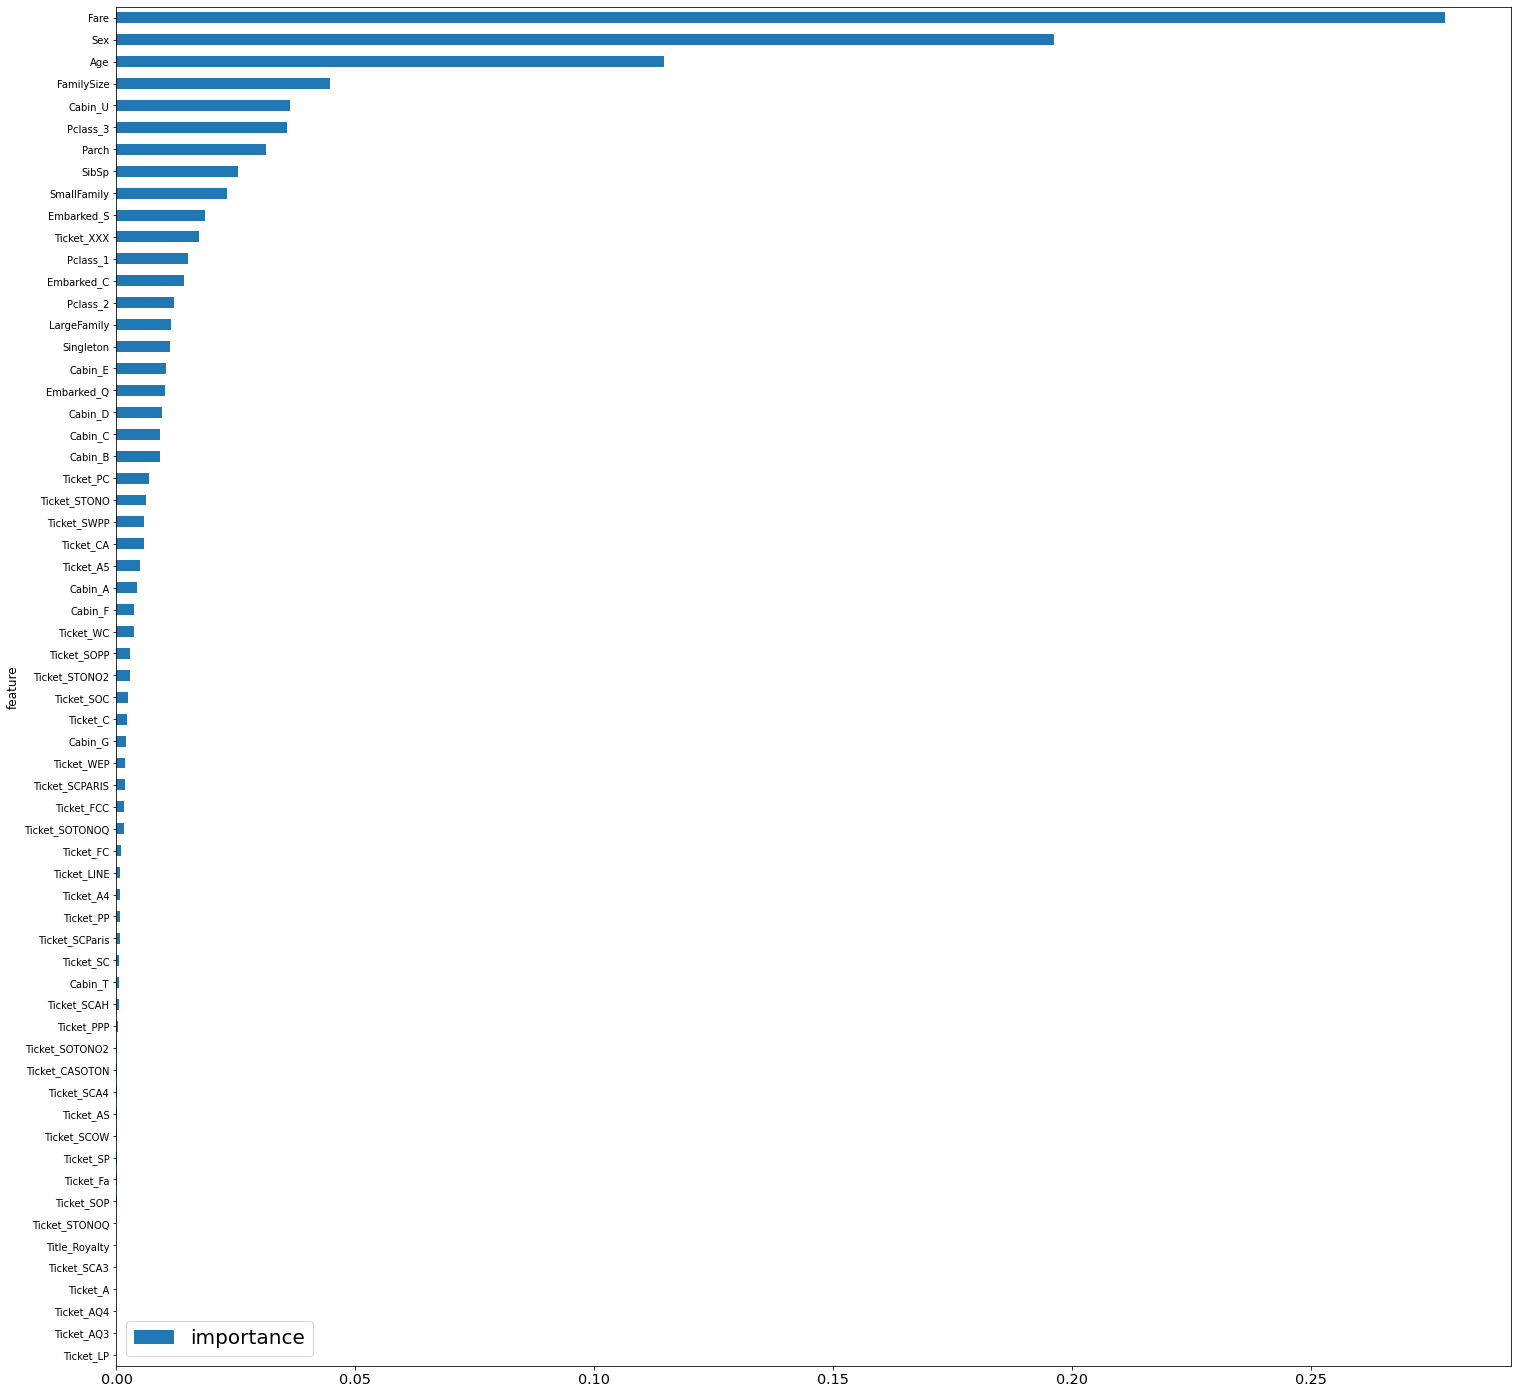

In [1190]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

![energy](./images/article_1/8.png)

**input**
- clf, <class 'sklearn.ensemble._forest.RandomForestClassifier'>
- train, shape(891, 62), column types: {int64: 7, float64: 2, uint8: 53}
- test, shape(418, 62), column types: {int64: 7, float64: 2, uint8: 53}

**output**
- model, <class 'sklearn.feature_selection._from_model.SelectFromModel'>, SelectFromModel(estimator=RandomForestClassifier(max_features='sqrt',
                                                 n_estimators=50),
                prefit=True)
- train_reduced, shape(891, 12) of float64
	- mean: 5.5741, variance: 332.1090, range: [0.0, 512.3292]

In [1191]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
test_reduced = model.transform(test)

### Let's try a simple model

**input**
- model, <class 'sklearn.feature_selection._from_model.SelectFromModel'>
- train_reduced, shape(891, 12) of float64
- targets, shape(891,) of int64

In [1192]:
model = RandomForestClassifier()
print('Cross-validation of : {0}'.format(model.__class__))
score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
print('CV score = {0}'.format(score))

Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.7968865733475613
